# **Libraries**

In [64]:
import os
import numpy as np
import pandas as pd 
import tensorflow as tf
import pandas
import sklearn
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout,Conv2DTranspose,Concatenate,UpSampling2D,Add,Input,BatchNormalization,Embedding,Reshape,UpSampling2D,Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy,MeanSquaredError
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Layer
from tensorflow.keras.utils import plot_model

# **Data**

In [65]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sprites/sprites_1788_16x16.npy
/kaggle/input/sprites/sprite_labels_nc_1788_16x16.npy


# **Load & Visualize**

In [66]:
sprites=np.load("/kaggle/input/sprites/sprites_1788_16x16.npy")
labels=np.load("/kaggle/input/sprites/sprite_labels_nc_1788_16x16.npy")

In [67]:
X={

    "pixel":sprites,
    "label":labels
    
}

Y={
    
    "output":sprites,
    
}

dataset=tf.data.Dataset.from_tensor_slices((X,Y))
dataset = dataset.prefetch(10).cache().batch(1)

In [68]:
def plotImageData(images,labels):
    
    plt.figure(figsize=(3,3))
    
    for i in range(16):
        
        plt.subplot(4,4,i+1)
        plt.imshow(images[i])
    
    plt.show()

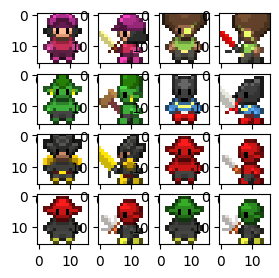

In [69]:
plotImageData(sprites[:16],labels[:16])

# **Noise Generators**

In [70]:
time_bar = 1 - np.linspace(0, 1.0, 100 + 1)
sprites=sprites/255
noise=np.random.normal(0,1,size=(16,16,3))
tempImg=sprites[0]

Sprites diffusion process demonstration at each timebar


/tmp/ipykernel_47/3517440590.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(25,5,i+1)


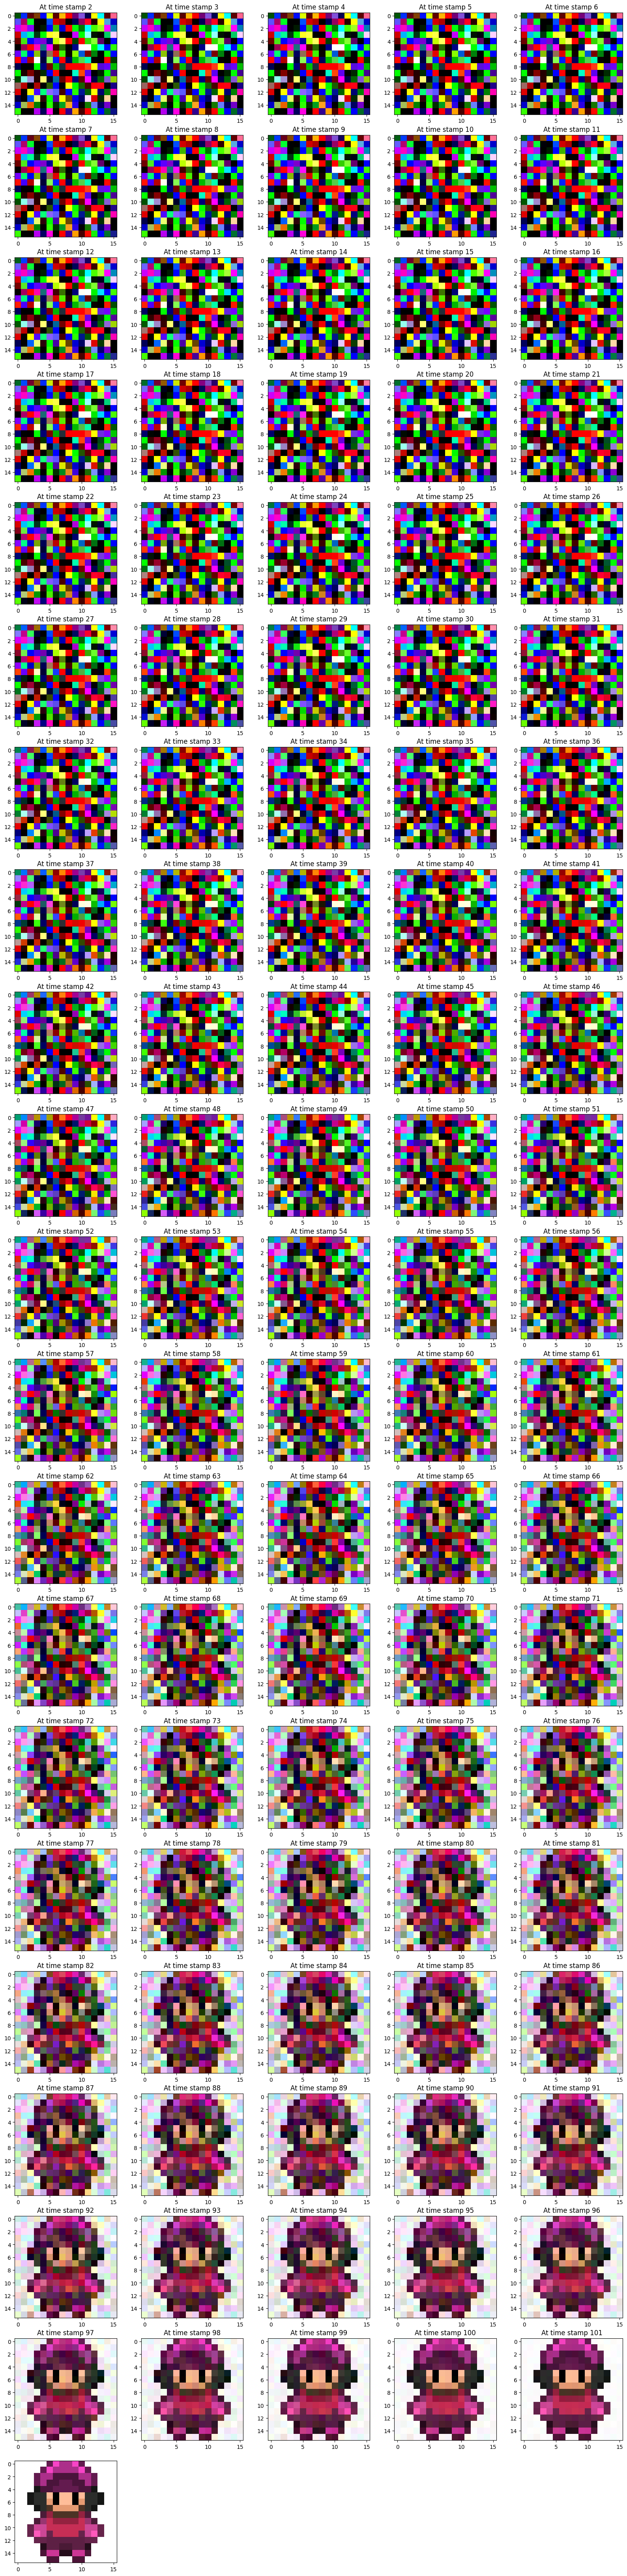

In [71]:
print("Sprites diffusion process demonstration at each timebar")
plt.figure(figsize=(20,100))
plt.tight_layout(pad=0.5)

for i in range(len(time_bar)):
    
    plt.title("At time stamp "+str(i+1))
    plt.subplot(25,5,i+1)
    plt.imshow(noise*time_bar[i]+tempImg*(1-time_bar[i]))

# **Design Model**

### **Generator**

In [72]:
class DownSampling2D(Layer):

    def __init__(self, filters,kernel_size,M2DKernel_Size, **kwargs):
        super(DownSampling2D, self).__init__(**kwargs)
        
        self.conv1=Conv2D(filters,kernel_size,activation="relu")
        self.conv2=Conv2D(filters,kernel_size,activation="relu")
        self.conv3=Conv2D(1,(1,1),activation="relu")

    
    def call(self,inp):
        
        x=inp
        x=self.conv1(x)
        x=self.conv2(x)
        y=self.conv3(x)
        
        return x,y

In [73]:
class UpSamplingD(Layer):

    def __init__(self, filters,kernel_size,units,reshape, **kwargs):
        super(UpSamplingD, self).__init__(**kwargs)
        
        self.reshape=reshape
        self.units=units
        
        self.conv1t=Conv2DTranspose(filters,kernel_size,activation="relu")
        self.upsampl=UpSampling2D()
        self.dense1=Dense(self.units)
        self.dense2=Dense(self.units)
    

    
    def call(self,inp):
        
        prev,embed,skip=inp
        y=Flatten()(embed)
        z=Flatten()(skip)
        x=self.conv1t(prev)
        x=self.upsampl(prev)
        x=Flatten()(x)
        x=Flatten()(Concatenate()([x,y]))
        
        k=Flatten()(Concatenate()([x,z]))
        
        l=Activation("relu")(Concatenate()([x,k]))

        
        x=self.dense1(l)
        x=self.dense2(x)
        x=tf.keras.layers.Reshape(self.reshape)(x)

        return x

In [74]:
class FeatureGate(Layer):

    def __init__(self,**kwargs):
        super(FeatureGate, self).__init__(**kwargs)
        
        self.dense1=Dense(2000,activation="relu")
        self.dense2=Dense(2000,activation="relu")
        self.dense4=Dense(2000,activation="relu")
        self.dense3=Dense(8*8*32,activation="relu")
        self.dense5=Dense(1024,activation="relu")
        self.my_variable = self.add_weight(
            name="my_variable",
            shape=(1,),
            initializer="zeros",
            trainable=True,
        )
    


    def  call(self,X):
        
        imgIp,emb=X
        
        emb=Flatten()(emb)
        
        dense1=self.dense5(emb)  
        
        y=Flatten()(imgIp)
        
        y=self.dense1(y)
        y=self.dense2(y)
        y=self.dense2(y)

 
        x=Concatenate()([dense1,y])
        y=self.dense3(x)
   
        y=tf.keras.layers.Reshape((8,8,32))(y)
        
        return y
        

In [75]:
ip=Input((16,16,3),name="pixel")
ip2=Input((5,),name="label")
x,x_skip1=DownSampling2D(filters=32,kernel_size=(3,3),M2DKernel_Size=(1,1))(ip)
x,x_skip2=DownSampling2D(filters=32,kernel_size=(2,2),M2DKernel_Size=(1,1))(x)
x,x_skip3=DownSampling2D(filters=32,kernel_size=(2,2),M2DKernel_Size=(1,1))(x)

embed=Embedding(5,128)(ip2)
flt=Flatten()(embed)
dense1=Dense(640)(flt)

x=FeatureGate()([x,dense1])

x=UpSamplingD(8,(1,1),12*12*16,(12,12,16))([x,dense1,x_skip3])
x=UpSamplingD(8,(1,1),14*14*8,(14,14,8))([x,dense1,x_skip2])
x=UpSamplingD(8,(1,1),16*16*3,(16,16,3))([x,dense1,x_skip1])
op=Conv2D(3,(1,1),activation="relu",name="output")(x)


In [76]:
generator=Model(inputs=[ip,ip2],outputs=[op])

In [77]:
generator.compile(optimizer="adam",loss="mae")

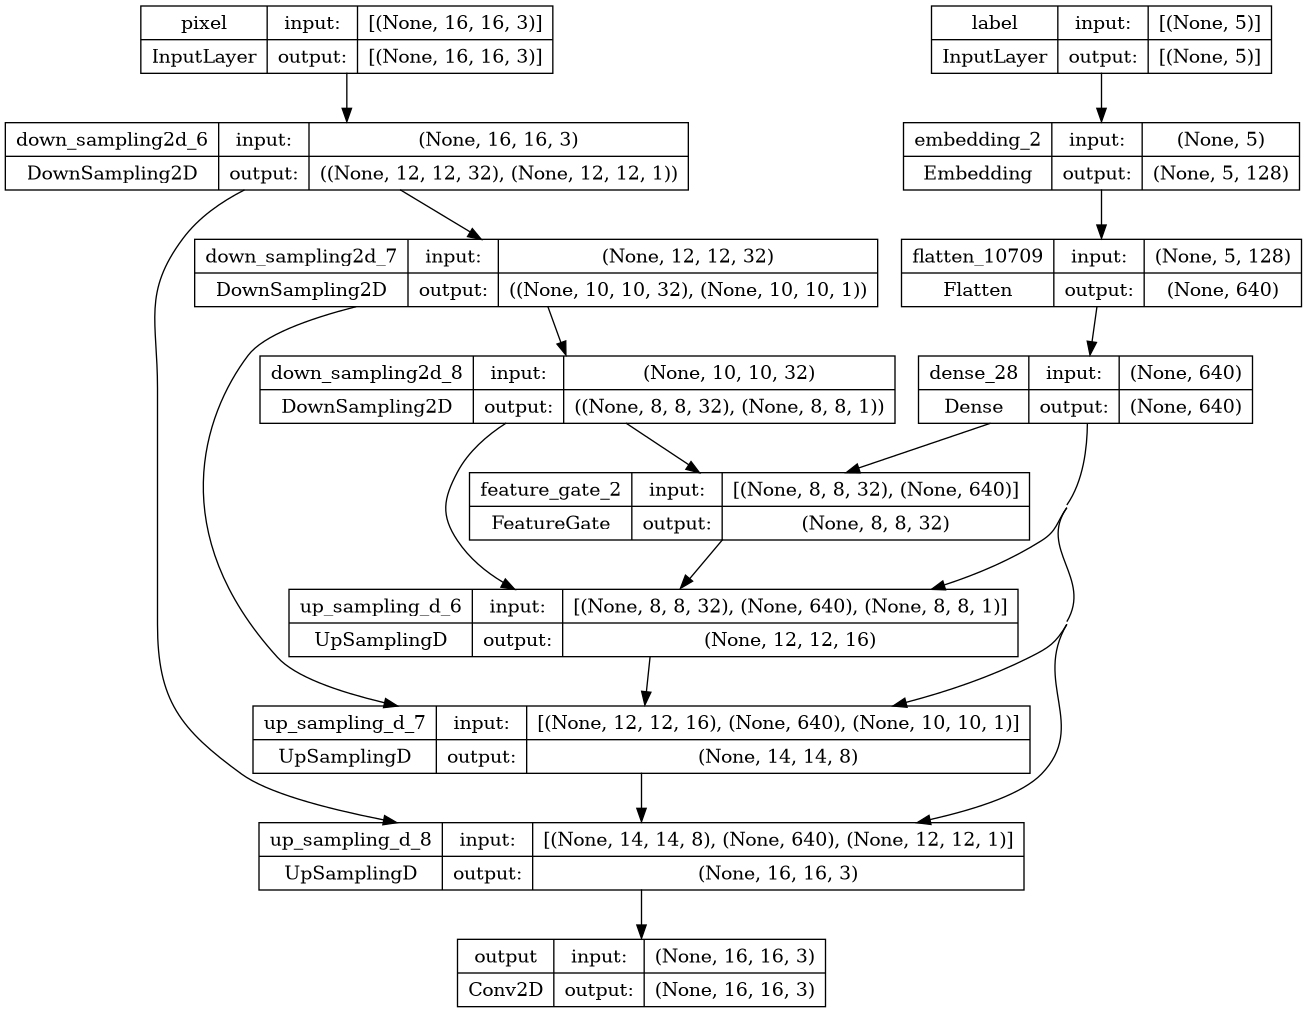

In [78]:
plot_model(generator,show_layer_names=True,show_shapes=True)

### **Discriminator**

In [79]:
discriminator=Sequential([
    
    Input((16,16,3)),    
    Conv2D(32,(2,2),activation="relu"),
    Conv2D(32,(2,2),activation="relu"),
    MaxPooling2D((2,2)),
    Conv2D(32,(2,2),activation="relu"),
    Conv2D(32,(2,2),activation="relu"),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(2048,activation="relu"),
    Dropout(0.2),
    Dense(1024,activation="relu"),
    Dropout(0.3),
    Dense(256,activation="relu"),
    Dense(1,activation="sigmoid")  
])

In [80]:
discriminator.compile(optimizer="adam",loss="mae")

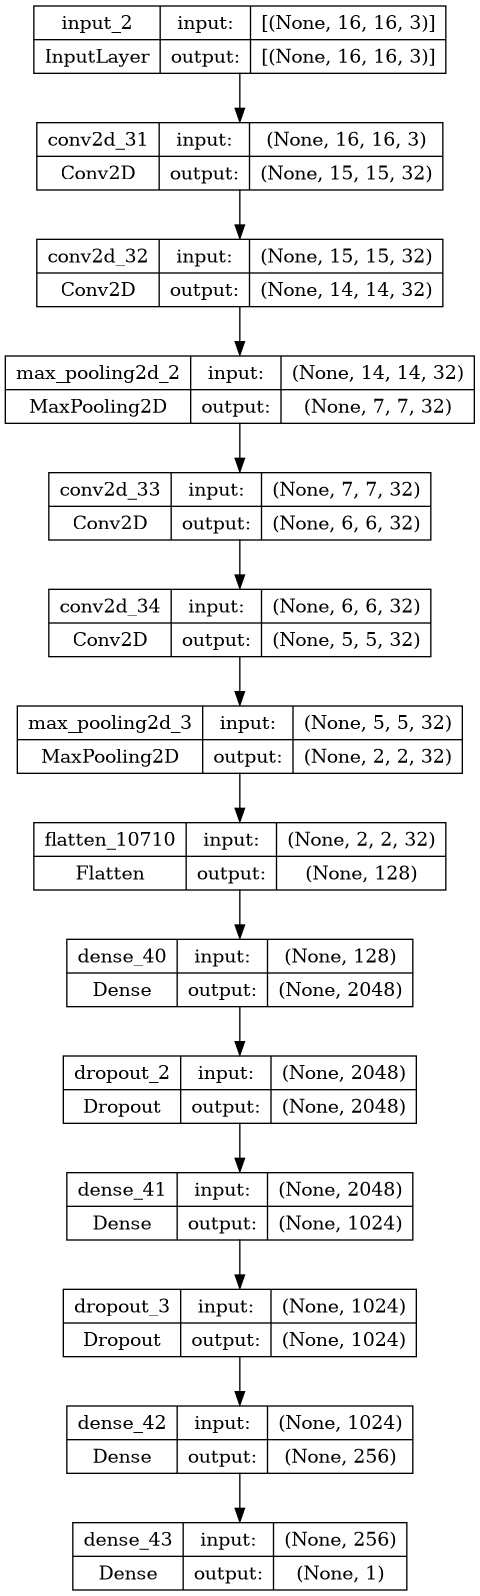

In [81]:
plot_model(discriminator,show_layer_names=True,show_shapes=True)

### **Diffusion Model**

In [82]:
dip=Input((16,16,3),name="dpixel")
dip2=Input((6,),name="dlabel")
dx,dx_skip1=DownSampling2D(filters=32,kernel_size=(3,3),M2DKernel_Size=(1,1))(dip)
dx,dx_skip2=DownSampling2D(filters=32,kernel_size=(2,2),M2DKernel_Size=(1,1))(dx)
dx,dx_skip3=DownSampling2D(filters=32,kernel_size=(2,2),M2DKernel_Size=(1,1))(dx)

dembed=Embedding(6,128)(dip2)
ddense1=Dense(200)(dembed)

dx=FeatureGate()([dx,ddense1])

dx=UpSamplingD(8,(1,1),12*12*16,(12,12,16))([dx,ddense1,dx_skip3])
dx=UpSamplingD(8,(1,1),14*14*8,(14,14,8))([dx,ddense1,dx_skip2])
dx=UpSamplingD(8,(1,1),16*16*1,(16,16,1))([dx,ddense1,dx_skip1])
dop=Conv2D(1,(1,1),activation="relu",name="doutput")(dx)

In [83]:
diffusion=Model(inputs=[dip,dip2],outputs=[dop])
diffusion.compile(optimizer="adam",loss="mae")

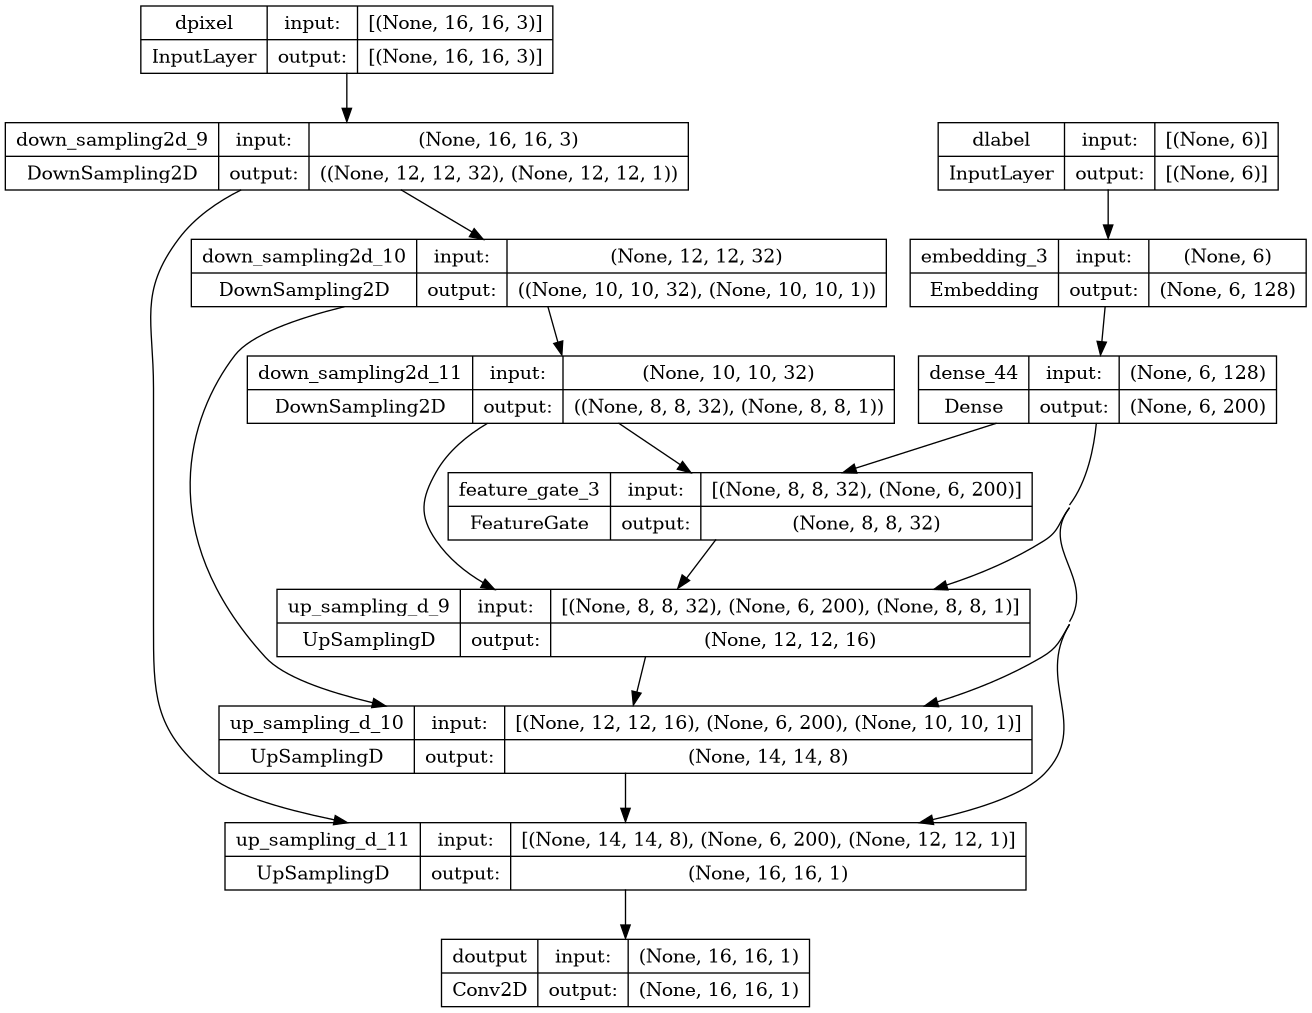

In [84]:
plot_model(diffusion,show_layer_names=True,show_shapes=True)

# **Training loop**

In [85]:
def train_loop(diff,noi):
    
    lss=tf.keras.losses.BinaryCrossentropy
            
    noise= tf.expand_dims(noi, axis=0)
  
    with tf.GradientTape() as tape:

        pred=diff({

            "pixel":noise,
            "label":tf.convert_to_tensor([[0,0,0,0,0]])
        })
    
                
(train_loop(generator,tempImg))

In [86]:
class difftorTrainer():
    
    
    def __init__(self,diffusion,generator,discriminator):
        
        self.diffusion=diffusion
        self.generator=generator
        self.discriminator=discriminator
    
    def lossOptFunction(self):
        
        self.difOptimizer=Adam(0.0001)
        self.genOptimizer=Adam(0.0001)
        self.disOptimizer=Adam(0.0000001)
        
        self.BCE=tf.keras.losses.BinaryFocalCrossentropy()
        self.MAE=MeanSquaredError()

    def returnModels(self):
        
        return (self.diffusion,self.generator,self.discriminator)

    def trainLoop(self,epochs=100):
    
        noise=np.random.normal(size=(16,16,3))
        noise=tf.expand_dims(noise,axis=0)
        
        for i in tqdm(range(epochs)):
            
            self.diffusion.trainable=True
            self.generator.trainable=True
            self.discriminator.trainable=True

            
            
            with tf.GradientTape() as diffTape:
                
                diffPred=self.diffusion({

            "dpixel":noise,
            "dlabel":tf.convert_to_tensor([[0,0,0,0,0,0]])
                })

                diffLoss=self.MAE(diffPred,noise)

           
            with tf.GradientTape() as genTape:
                
                genPred=self.generator({

            "pixel":noise,
            "label":tf.convert_to_tensor([[0,0,0,0,0]])
                })
                
                genLoss=self.MAE(genPred,noise)

                

            with tf.GradientTape() as disTape:
                
                disPred=self.discriminator(noise)
                
                disLoss=self.BCE(disPred,np.array([0.06]))
            
            
            diffGrad=diffTape.gradient(diffLoss,self.diffusion.trainable_variables)
            genGrad=genTape.gradient(genLoss,self.generator.trainable_variables)
            disGrad=disTape.gradient(disLoss,self.discriminator.trainable_variables)
            
            self.difOptimizer.apply_gradients(zip(diffGrad,self.diffusion.trainable_variables))
            self.genOptimizer.apply_gradients(zip(genGrad,self.generator.trainable_variables))
            self.disOptimizer.apply_gradients(zip(disGrad,self.discriminator.trainable_variables))
            
#             del diffLoss
#             del genLoss
#             del disLoss
#             del diffGrad
#             del genGrad
#             del disGrad
#             del diffPred
#             del genPred
#             del disPred
            
            print(i)
            print(diffLoss,genLoss,disLoss)
    


In [87]:
obj=difftorTrainer(diffusion,generator,discriminator)
obj.lossOptFunction()
obj.returnModels()


(<keras.src.engine.functional.Functional at 0x7cbf111bb970>,
 <keras.src.engine.sequential.Sequential at 0x7cbf111aee00>)

In [88]:
try:
    obj.trainLoop()
except KeyboardInterrupt:
    
    print("---------XX----------")

  0%|          | 0/100 [00:00<?, ?it/s]

0
tf.Tensor(0.9582547092179566, shape=(), dtype=float64) tf.Tensor(0.9593419357494575, shape=(), dtype=float64) tf.Tensor(0.3980898737271352, shape=(), dtype=float64)
1
tf.Tensor(0.9207670129567038, shape=(), dtype=float64) tf.Tensor(0.9350860915664396, shape=(), dtype=float64) tf.Tensor(0.3980164826123203, shape=(), dtype=float64)
2
tf.Tensor(0.8739921268600952, shape=(), dtype=float64) tf.Tensor(0.864684138161022, shape=(), dtype=float64) tf.Tensor(0.39794285135161783, shape=(), dtype=float64)
3
tf.Tensor(0.8475619912043011, shape=(), dtype=float64) tf.Tensor(0.7482606678871145, shape=(), dtype=float64) tf.Tensor(0.39786935373021093, shape=(), dtype=float64)
4
tf.Tensor(0.8315131634444688, shape=(), dtype=float64) tf.Tensor(0.8442081728167184, shape=(), dtype=float64) tf.Tensor(0.397795740603062, shape=(), dtype=float64)
5
tf.Tensor(0.8214458598879865, shape=(), dtype=float64) tf.Tensor(0.6491059768784952, shape=(), dtype=float64) tf.Tensor(0.39772213654952915, shape=(), dtype=float6